# 94-775/95-865: Prediction and Model Validation

Author: George H. Chen (georgechen [at symbol] cmu.edu)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

np.random.seed(0)

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

## Loading in the data and a quick data inspection

In [3]:
train_dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

In [4]:
train_images = np.array([image.numpy() for image, label in train_dataset])

In [5]:
train_labels = np.array([label for image, label in train_dataset])

In [6]:
train_images.shape

(60000, 1, 28, 28)

In [7]:
train_labels

array([5, 0, 4, ..., 5, 6, 8])

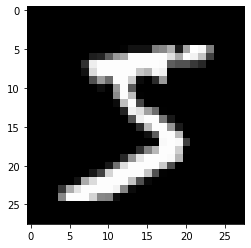

In [8]:
plt.imshow(train_images[0][0], cmap='gray')

In [9]:
train_images = train_images[:2000]
train_labels = train_labels[:2000]

In [10]:
train_images_flat = train_images.reshape(len(train_images), -1)  # flattens out each training image

In [11]:
print(train_images_flat.shape)

(2000, 784)


## Classification using $k$-nearest neighbors

In [12]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(train_images_flat, train_labels)

KNeighborsClassifier(n_neighbors=1)

In [13]:
predicted_train_labels = classifier.predict(train_images_flat)

In [14]:
predicted_train_labels

array([5, 0, 4, ..., 5, 2, 0])

In [15]:
error_rate = np.mean(predicted_train_labels != train_labels)
print(error_rate) 
#the reason why this equals to 0 is that we set k=1, we are predicting the same dataset that we fit the model
#except there are some corner cases, same feature vector but different label

0.0


## Choosing hyperparameter $k$ (number of nearest neighbors) using simple data splitting

In [16]:
from sklearn.model_selection import train_test_split

proper_train_images_flat, val_images_flat, proper_train_labels, val_labels = \
    train_test_split(train_images_flat, train_labels, test_size=0.2, random_state=0)

In [17]:
lowest_error = np.inf
best_k = None
for k in 2**np.arange(0, 8):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(proper_train_images_flat, proper_train_labels)
    predicted_val_labels = classifier.predict(val_images_flat)
    error = np.mean(predicted_val_labels != val_labels)
    print('k:', k, 'error rate:', error)
    
    if error < lowest_error:
        lowest_error = error
        best_k = k

print('Best k:', best_k, 'error rate:', lowest_error)

k: 1 error rate: 0.1075
k: 2 error rate: 0.13
k: 4 error rate: 0.1325
k: 8 error rate: 0.1475
k: 16 error rate: 0.1675
k: 32 error rate: 0.2025
k: 64 error rate: 0.26
k: 128 error rate: 0.33
Best k: 1 error rate: 0.1075


## Choosing hyperparameter $k$ using 5-fold cross validation

In [23]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
i=0
for proper_train_indices, val_indices in kf.split(train_images_flat):
    print(len(proper_train_indices), len(val_indices))
    i+=1
    print(i)
    if i==1:
        break

1600 400
1


In [24]:
from sklearn.model_selection import KFold

lowest_cross_val_error = np.inf
best_k = None

kf = KFold(n_splits=5, shuffle=True, random_state=0)
for k in 2**np.arange(0, 8):
    errors = []
    for proper_train_indices, val_indices in kf.split(train_images_flat):
        proper_train_features = train_images_flat[proper_train_indices]
        proper_train_labels = train_labels[proper_train_indices]
        val_features = train_images_flat[val_indices]
        val_labels = train_labels[val_indices]
        
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(proper_train_features, proper_train_labels)
        predicted_val_labels = classifier.predict(val_features)
        error = np.mean(predicted_val_labels != val_labels)
        errors.append(error)
        
    cross_val_error = np.mean(errors)
    print('k:', k, 'cross validation error:', cross_val_error)

    if cross_val_error < lowest_cross_val_error:
        lowest_cross_val_error = cross_val_error
        best_k = k

print('Best k:', best_k, 'cross validation error:', lowest_cross_val_error)

k: 1 cross validation error: 0.092
k: 2 cross validation error: 0.10899999999999999
k: 4 cross validation error: 0.10400000000000001
k: 8 cross validation error: 0.1115
k: 16 cross validation error: 0.1335
k: 32 cross validation error: 0.1595
k: 64 cross validation error: 0.198
k: 128 cross validation error: 0.269
Best k: 1 cross validation error: 0.092


## Using different classifiers

It's simple to work with other classifiers in scikit-learn. 

For example, here is how one can use random forest classifiers using the number of random features to use at each split (`max_features`) 
and the minimum number of samples allowed in a leaf cell (`min_samples_leaf`) as hyperparameters 

(there are other hyperparameters as well, but we're just using the scikit-learn default values in this demo--if you care about actually tuning the performance of a random forest classifier carefully, then you should look into what the other hyperparameters do by reading the documentation). 

Note that the default number of trees used (which can also be manually set via the parameter `n_estimators`) is 100.

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(max_features='auto', min_samples_leaf=1, random_state=0)  
#n_estimator: number of trees, default=100
#max_features: for each split, randomly choose k features and optimize the threshold, auto=sqrt of number of features
#min_samples_leaf: minimum number of points that are allowed in the leaf node
rf_classifier.fit(train_images_flat, train_labels)
rf_predicted_train_labels = rf_classifier.predict(train_images_flat)
rf_error = np.mean(rf_predicted_train_labels != train_labels)
print(rf_error)  # training set error, min=1 and predict on train, you will always get 0 error

0.0


Next, we see cross-validation for random forests. Importantly, now we sweep over two hyperparameters.

In [26]:
lowest_cross_val_error = np.inf
best_hyperparameter_setting = None

num_features = train_images_flat.shape[1]
hyperparameter_settings = [(max_features, min_samples_leaf)
                           for max_features in [int(np.ceil(np.sqrt(num_features) / 4)),
                                                int(np.ceil(np.sqrt(num_features))),
                                                int(np.ceil(np.sqrt(num_features) * 4))]
                           for min_samples_leaf in [1, 2, 4, 8, 16]]

kf = KFold(n_splits=5, shuffle=True, random_state=0)
for hyperparameter_setting in hyperparameter_settings:
    max_features, min_samples_leaf = hyperparameter_setting
    errors = []
    for proper_train_indices, val_indices in kf.split(train_images_flat):
        proper_train_features = train_images_flat[proper_train_indices]
        proper_train_labels = train_labels[proper_train_indices]
        val_features = train_images_flat[val_indices]
        val_labels = train_labels[val_indices]
        
        classifier = RandomForestClassifier(max_features=max_features,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=0)
        classifier.fit(proper_train_features, proper_train_labels)
        predicted_val_labels = classifier.predict(val_features)
        error = np.mean(predicted_val_labels != val_labels)
        errors.append(error)
        
    cross_val_error = np.mean(errors)
    print('Hyperparameter:', hyperparameter_setting, 'cross validation error:', cross_val_error)

    if cross_val_error < lowest_cross_val_error:
        lowest_cross_val_error = cross_val_error
        best_hyperparameter_setting = hyperparameter_setting

print('Best hyperparameter:', best_hyperparameter_setting, 'cross validation error:', lowest_cross_val_error)

Hyperparameter: (7, 1) cross validation error: 0.0895
Hyperparameter: (7, 2) cross validation error: 0.09
Hyperparameter: (7, 4) cross validation error: 0.10599999999999998
Hyperparameter: (7, 8) cross validation error: 0.127
Hyperparameter: (7, 16) cross validation error: 0.1485
Hyperparameter: (28, 1) cross validation error: 0.08549999999999999
Hyperparameter: (28, 2) cross validation error: 0.093
Hyperparameter: (28, 4) cross validation error: 0.09200000000000001
Hyperparameter: (28, 8) cross validation error: 0.1135
Hyperparameter: (28, 16) cross validation error: 0.14350000000000002
Hyperparameter: (112, 1) cross validation error: 0.08600000000000001
Hyperparameter: (112, 2) cross validation error: 0.09100000000000001
Hyperparameter: (112, 4) cross validation error: 0.099
Hyperparameter: (112, 8) cross validation error: 0.11599999999999999
Hyperparameter: (112, 16) cross validation error: 0.14900000000000002
Best hyperparameter: (28, 1) cross validation error: 0.08549999999999999


## Finally actually looking at the test data

In [27]:
test_dataset = torchvision.datasets.MNIST(root='data/',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)
test_images = np.array([image.numpy() for image, label in test_dataset])
test_labels = np.array([label for image, label in test_dataset])

test_images = test_images[:500]
test_labels = test_labels[:500]
test_images_flat = test_images.reshape(len(test_images), -1)  # flattens out each test image

In [28]:
final_knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
final_knn_classifier.fit(train_images_flat, train_labels)
predicted_test_labels = final_knn_classifier.predict(test_images_flat)
test_set_error = np.mean(predicted_test_labels != test_labels)
print(test_set_error)

0.138


In [29]:
best_max_features, best_min_samples_split = best_hyperparameter_setting
final_rf_classifier = RandomForestClassifier(max_features=best_max_features,
                                             min_samples_leaf=best_min_samples_split,
                                             random_state=0)
final_rf_classifier.fit(train_images_flat, train_labels)
predicted_test_labels = final_rf_classifier.predict(test_images_flat)
test_set_error = np.mean(predicted_test_labels != test_labels)
print(test_set_error)

0.09


Note that in general the cross validation error is not going to perfectly match up with the test set error.

## Confusion matrix

We can visualize to see where (in terms of which classes) predictions agree or disagree with the true labels on the test set. This can help us quickly see which classes seem to be hard cases.

In [30]:
from sklearn.metrics import plot_confusion_matrix

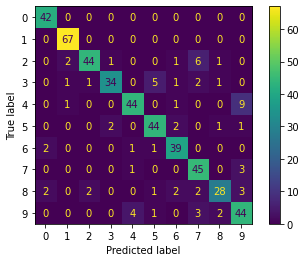

In [31]:
plot_confusion_matrix(final_knn_classifier, test_images_flat, test_labels)

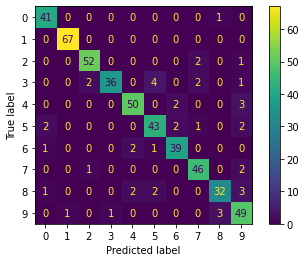

In [32]:
plot_confusion_matrix(final_rf_classifier, test_images_flat, test_labels)